<a href="https://colab.research.google.com/github/YanivZimmer/DST-Course-Project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Measuring FS



Imports and random seed

In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.svm import SVR
from typing import List
import matplotlib.pyplot as plt

random_seed = 7
np.random.seed(random_seed)

Transform categorical data into numerical representation

In [51]:
# https://www.kaggle.com/code/willkoehrsen/introduction-to-feature-selection?scriptVersionId=4214886&cellId=53

def encode_categorical(df):
  # Create a label encoder
  label_encoder = LabelEncoder()

  # List for storing categorical indices
  cat_indices = []
  for i, col in enumerate(df):
    if df[col].dtype == 'object':
      # Map the categorical features to integers
      df[col] = label_encoder.fit_transform(np.array(df[col].astype(str)).reshape((-1,)))
      cat_indices.append(i)
  return df, cat_indices

### Datasets
MyDataset load and contain data set from UC Irvine Machine Learning Repository.

In [52]:
# maybe create a DTO that contains a dataset, that loads dataset by name
class MyDataset:
  def __init__(self,name:str, id: int, target: str, is_clsf: bool):
    self.name=name
    #self.describe=self.describe(name)
    self.target = target  # Name of the label column
    self.is_clsf=is_clsf  # Indicate whether the data set is for classification task or not (regression)
    url = f'https://archive.ics.uci.edu/static/public/{id}/data.csv'
    self.df, _=encode_categorical(pd.read_csv(url))
    self.data=self.df.loc[:, self.df.columns != target]
    self.labels=self.df[target]

  def get_data_with_features(self, features:List[int]):
    return self.data.iloc[:, features]

  def feature_names_to_idx(self, features:List[str])->List[int]:
    return [self.data.columns.get_loc(f) for f in features]

  def feature_idx_to_names(self, features:List[int])->List[str]:
    features_names = self.data.columns.tolist()
    return [features_names[idx] for idx in features]

Datasets:<br>
The datasets were taken from 'UC Irvine Machine Learning Repository'.<br>
<a href="https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success">Students dropout/success prediction</a>:<br>
Ds of classification task, predicting whether a student will drop or success based on his stats.<br>
<a href="https://archive.ics.uci.edu/dataset/1/abalone">Abalon age</a>:<br>
Ds of regression task, predicting the age of abalone from physical measurements.<br>
<a href="https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset">Poisonous mushrooms</a>:<br>
Ds of classification task, predicting whether a mushroom is poisonous or edible.<br>
<a href="https://archive.ics.uci.edu/dataset/2/adult">Salaries</a>:<br>
Ds of classification task, predicting whether a salary of person is above or below 50k.<br>
<a href="https://archive.ics.uci.edu/dataset/925/infrared+thermography+temperature+dataset">Infrared Thermography Temperature</a>:<br>
Ds of regression task.<br>
The ds contains temperatures read from various locations of inferred images about patients, with the addition of oral temperatures measured for each individual. The dataset is intended to be used in a regression task to predict the oral temperature using the environment information as well as the thermal image readings.<br>
The original ds contain 2 target column, one for oral temperature measured in fast mode and the second measured in monitor mode, we will remove the first target column and predict the second.

In [53]:
students_ds = MyDataset('Student Success Rate', 697, 'Target', True)
abalon_ds = MyDataset('Abalon age', 1, 'Rings', False)
mushrooms_ds = MyDataset('Mushrooms', 848, 'class', True)
salaries_ds = MyDataset('Salaries', 2, 'income', True)
infrared_thermography_temperature_ds = MyDataset('Infrared Thermography Temperature', 925, 'aveOralM', False)
infrared_thermography_temperature_ds.data = infrared_thermography_temperature_ds.data.drop(['aveOralF', 'Distance'], axis=1)  # Column Distance contain NaN, column aveOralF is a target column as well
infrared_thermography_temperature_ds.df = infrared_thermography_temperature_ds.df.drop(['aveOralF', 'Distance'], axis=1)
db = [students_ds, abalon_ds, mushrooms_ds, salaries_ds, infrared_thermography_temperature_ds]

#### Measuring features
This function receives subset of features and measure them using a Linear Regression (for regression tasks) or Gradient Boosting Classifier (for classification tasks).

In [54]:
def test_features(X, y, is_clsf):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)

  scaler = StandardScaler()
  if is_clsf:
    lr = GradientBoostingClassifier(random_state=random_seed)
    #lr = LogisticRegression(random_state=random_seed)
  else:
    lr = LinearRegression()

  # Fit the scaler on the training features and transform these in one go
  X_train_std = scaler.fit_transform(X_train)

  # Fit the logistic regression model on the scaled training data
  lr.fit(X_train_std, y_train)

  # Scaler the test features
  X_test_std = scaler.transform(X_test)

  # Predict diabetes presence on the scaled test set
  y_pred = lr.predict(X_test_std)

  # Print accuracy metrics for classification and root mean square error for regression
  if is_clsf:
    return accuracy_score(y_test, y_pred)
  else:
    return np.sqrt(mean_squared_error(y_test, y_pred))

Selecting features based on the importance the model (ExtraTreesClassifier for classification and SVR for regression) gave to each feature.

In [55]:
# https://scikit-learn.org/stable/modules/feature_selection.html
def auto_feature_selection(X, y, is_clsf, max_features):
  sel = VarianceThreshold()
  X_new = sel.fit_transform(X)

  if is_clsf:
    clf = ExtraTreesClassifier(n_estimators=50, random_state=random_seed)
  else:
    clf = SVR(kernel="linear")

  clf = clf.fit(X_new, y)
  model = SelectFromModel(clf, prefit=True, max_features=max_features)
  return model

#### Measure score of normal and auto FS features

In [56]:
def compare_fs_to_baseline(ds, max_features):
  X, y = ds.data, ds.labels
  train_X, test_X, train_y, test_y = train_test_split(ds.data, ds.labels, test_size = 0.5, random_state = random_seed)

  base_score = test_features(X, y, ds.is_clsf)

  model = auto_feature_selection(train_X, train_y, ds.is_clsf, max_features)
  trnsf_X = model.transform(test_X)
  fs_score = test_features(trnsf_X, test_y, ds.is_clsf)
  return fs_score, base_score, trnsf_X.shape[1]

Test arbitrary featrues

In [57]:
def test_benchmark_for_dataset(dataset:str,max_features: int)->float:
  for ds in db:
    if ds.name != dataset:
      continue
    else:
      auto_fs_score, base_score, auto_fs_n_selected_features = compare_fs_to_baseline(ds, max_features)
      return auto_fs_score, base_score, auto_fs_n_selected_features

In [58]:
def test_features_for_dataset(dataset:str,features:List[int],max_features: int)->float:
  for ds in db:
    if ds.name != dataset:
      continue
    else:
      data = ds.get_data_with_features(features)
      my_score = test_features(data, ds.labels, ds.is_clsf)
      n_selected_features = data.shape[1]
      return my_score, n_selected_features

In [59]:
auto_fs_score, base_score, auto_fs_n_selected_features = test_benchmark_for_dataset(db[0].name, 5)
my_score, n_selected_features = test_features_for_dataset(db[0].name, [0, 1, 3, 5], 5)
print("my_score",my_score)
print("auto_fs_score",auto_fs_score)
print("base_score",base_score)
print(n_selected_features)          # selected features on my fs
print(auto_fs_n_selected_features)  # selectes features on auto fs
print(db[0].data.shape[1])          # num features

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


my_score 0.5753012048192772
auto_fs_score 0.7274096385542169
base_score 0.759789156626506
4
5
36


#### Usage example
The new fs method may be called as well inside compare_fs_to_baseline the same way as the second model and the score can be added as well, this way we can compare results to another fs method.

In [60]:
base_scores = []
fs_tree_score = []
base_n_features = []
tree_n_features = []
# for ds in db:
#   print('1')

#   tree_score, base_score, tree_n_feat = compare_fs_to_baseline(ds, 5)

#   base_scores.append(tree_score)
#   fs_tree_score.append(base_score)
#   tree_n_features.append(tree_n_feat)
#   base_n_features.append(ds.df.shape[1])

# Novel Feature selction and information measures
Here we will present out novel feature selections techniques based on measure from information theory and regularization



**Imports and dataset**

In [61]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

#from sklearn.datasets import load_boston
#boston = load_boston()
# Load the Boston Housing dataset

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X_boston = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y_boston = raw_df.values[1::2, 2]

# Extract the features and target variable
# Generate synthetic data
#X, y = make_regression(n_samples=1000, n_features=100, n_informative=10, random_state=42)

**Utilities**

In [62]:
def get_top_k(arr,k):
  ind = np.argpartition(arr, -k)[-k:]
  return ind,arr[ind]

**L1 regularization**
TODO - rank 2k features by l1, and then choose topk by entropy

In [63]:
def get_features_by_l1(X_train,y_train,k, vis=True):
  # Create a Lasso model
  lasso = Lasso(alpha=0.1, max_iter=10000)
  # Fit the model
  lasso.fit(X_train, y_train)
  # Get the coefficients
  coef = lasso.coef_
  if vis:
    print("l1_coef",coef)
  # Print the non-zero coefficients and their indices
  # print("Non-zero coefficients and their indices:")
  # nonzero_indices = np.nonzero(coef)[0]
  # for i in nonzero_indices:
  #     print(f"Feature {i}: {coef[i]}")
  return get_top_k(np.abs(coef),k),coef

**Custom regularization**

# Calculate entropy

In [64]:
class EntropyRegularizerFeatureSelector:
    def __init__(self,X):
      self.feature_entropies = self.get_features_entropies(X)

    @staticmethod
    def entropy(feature_values):
      hist, bin_edges = np.histogram(feature_values, bins='auto')
      probabilities = hist / np.sum(hist)
      entropy_value = -np.sum([p * log2(p) if p > 0 else 0 for p in probabilities])
      return entropy_value

    def get_features_entropies(self,dataset):
      # Calculate entropy for each feature
      features_entropies = [EntropyRegularizerFeatureSelector.entropy(dataset[:, i]) for i in range(dataset.shape[1])]
      return np.array(features_entropies)

    def custom_regularization(self,coef, alpha):
      return alpha * (np.sum(np.abs(coef/(np.power(self.feature_entropies,1))))) * 1




Entropy and L1 multisteps

In [65]:
def l1_then_entropy(X_train,y_train,k):
  candidates = get_features_by_l1(X_train,y_train,2*k)
  EntropyRegularizerFeatureSelector(X_train)
  sorted_items = sorted(candidates[0], key=lambda x: EntropyRegularizerFeatureSelector.entropy(X_train[x]), reverse=True)

  # Extract keys from the sorted items
  #top_k_keys = [key for key, _ in sorted_items[:k]]
  print("sorted_items",sorted_items)

  #print(top_k_keys)
  return sorted_items[:k]



In [66]:
from math import log2


In [67]:
from scipy.optimize import minimize
class MyRegulaizerBase:
  def __init__(self,X,y,regulaizer,alpha=0.1):
    self.X=X
    self.y=y
    self.regulaizer=regulaizer
    self.alpha=alpha

  def objective(self,coef, X, y, alpha):
    residual = y - np.dot(X, coef)
    loss = 0.5 * np.sum(residual ** 2)
    regularization = self.regulaizer.custom_regularization(coef, alpha)
    return loss + regularization

  def get_features_and_coef(self,k):
    # Initialize the coefficients
    initial_coef = np.zeros(self.X.shape[1])

    # Optimize the objective function
    result = minimize(self.objective, initial_coef, args=(self.X, self.y, self.alpha), method='L-BFGS-B')

    # Get the optimized coefficients
    coef = result.x

    # Print the non-zero coefficients and their indices
    # print("Non-zero coefficients and their indices:")
    # nonzero_indices = np.nonzero(coef)[0]
    # for i in nonzero_indices:
    #     print(f"Feature {i}: {coef[i]}")

    return get_top_k(np.abs(coef),k),coef



In [68]:
X_boston.shape

(506, 13)

In [69]:
db[0].labels

0       0
1       2
2       0
3       2
4       2
       ..
4419    2
4420    0
4421    0
4422    2
4423    2
Name: Target, Length: 4424, dtype: int64

In [70]:
selector=MyRegulaizerBase(db[0].data.to_numpy(),db[0].labels.to_numpy(),EntropyRegularizerFeatureSelector(db[0].data.to_numpy()))
entropy_features, _=selector.get_features_and_coef(5)


In [71]:
entropy_features[0]
l1_feat=get_features_by_l1(db[0].data.to_numpy(),db[0].labels.to_numpy(),5)

l1_coef [ 0.00000000e+00 -2.70411446e-03 -0.00000000e+00 -3.29704801e-05
 -0.00000000e+00  1.79158160e-04  7.98040507e-04 -0.00000000e+00
  0.00000000e+00  1.07690735e-03  7.91470775e-04  0.00000000e+00
  1.44117514e-03 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -6.41206708e-03
  0.00000000e+00 -3.02354499e-02 -0.00000000e+00 -1.47854714e-02
  1.61685875e-02  4.46169563e-03  0.00000000e+00 -1.03441775e-02
 -4.51032192e-02 -1.50654438e-02  1.75910184e-01  2.62548937e-02
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00]


In [72]:
#get_features_by_l1(db[0].data.to_numpy(),db[0].labels.to_numpy(),5)

*Those were the results for db[0]*

l1_score 0.7356927710843374

my_score-with entropy 0.7424698795180723

auto_fs_score 0.7274096385542169

base_score 0.759789156626506


**Entropy regularization**

Feature Correlation

Cross correlation:

The correlation coefficient ranges from -1 to 1, where:

A value close to 1 indicates a strong positive correlation (as one variable increases, the other tends to increase as well).

A value close to -1 indicates a strong negative correlation (as one variable increases, the other tends to decrease).

A value close to 0 indicates little or no linear correlation between the two variables.

TODO add correlation to labels

In [73]:
class CrossCorrRegularizerFeatureSelector:
    def __init__(self,X):
      self.feature_correlations = self.corr_per_feature(X)

    # def calc_corr(self,X):
    #   correlations = [np.corrcoef(feature, X[:, i])[0, 1] for i in range(X.shape[1])]
    #   return correlations

    def corr_per_feature(self,X):
      corr_matrix = np.corrcoef(X, rowvar=False)
      # Calculate the sum of absolute correlation coefficients for each feature
      feature_correlations = []
      for i in range(X.shape[1]):
          # Get the absolute correlations between the current feature and all other features
          abs_corrs = np.abs(corr_matrix[i, :])
          # Exclude the correlation with itself (diagonal element)
          abs_corrs = np.delete(abs_corrs, i)
          # Calculate the sum of absolute correlations
          feature_correlations.append(np.sum(abs_corrs))
      return np.array(feature_correlations)

      # Print the feature correlations
      #feature_correlations = corr_per_feature(X)
    def custom_regularization(self,coef, alpha):
      return alpha * (np.sum(np.abs(coef/(np.power(self.feature_correlations,1))))) * 1




Kandell

In [74]:
from scipy.stats import kendalltau

class KandellCorrRegularizerFeatureSelector:
    def __init__(self,X):
      self.feature_correlations = self.corr_per_feature(X)

    # def calc_corr(self,X):
    #   correlations = [np.corrcoef(feature, X[:, i])[0, 1] for i in range(X.shape[1])]
    #   return correlations


    def kendall_corrcoef(self,matrix):
      # Get the number of variables (columns)
      num_vars = matrix.shape[1]
      # Create an empty matrix to store Kendall tau coefficients
      kendall_matrix = np.zeros((num_vars, num_vars))

      # Iterate over each pair of variables (columns)
      for i in range(num_vars):
          for j in range(num_vars):
              if i <= j:
                  # Compute Kendall's tau coefficient
                  tau, _ = kendalltau(matrix[:, i], matrix[:, j])
                  kendall_matrix[i, j] = tau
                  kendall_matrix[j, i] = tau  # The matrix is symmetric

      return kendall_matrix

    def corr_per_feature(self,X):
      corr_matrix = self.kendall_corrcoef(X)#np.corrcoef(X, rowvar=False)
      # Calculate the sum of absolute correlation coefficients for each feature
      feature_correlations = []
      for i in range(X.shape[1]):
          # Get the absolute correlations between the current feature and all other features
          abs_corrs = np.abs(corr_matrix[i, :])
          # Exclude the correlation with itself (diagonal element)
          abs_corrs = np.delete(abs_corrs, i)
          # Calculate the sum of absolute correlations
          feature_correlations.append(np.sum(abs_corrs))
      return np.array(feature_correlations)

      # Print the feature correlations
      #feature_correlations = corr_per_feature(X)
    def custom_regularization(self,coef, alpha):
      return alpha * (np.sum(np.abs(coef/(np.power(self.feature_correlations,1))))) * 1

# Visualization
Visualize features important and their Information Theory values

In [75]:
def visualize(coffs, all_entropy, cross_corr,kandell_corr, k, feature_names=None):
    '''
    Visualize plot of entropy for all features in sequntial order, by the data give in all_entropy
    Visualize plot of cross corr for all features in sequntial order, by the data give in cross_corr
    Visualize coefficent of top k features, where there labels are feature index
    All of those visualizations in a single window
    '''
    num_features = len(all_entropy)
    n_coefs=len(coffs.keys())
    for i,(name,coff) in enumerate(coffs.items()):
      print("coffs",len(coff),coff[0])
      top_k_indices = sorted(range(len(coff)), key=lambda i: abs(coff[i]), reverse=True)[:k]
      top_k_coefficients = [coff[i] for i in top_k_indices]
      top_k_labels = [feature_names[i] if feature_names else f'Feature {i}' for i in top_k_indices]

      #Sort top k coefficients by index, to make them alligned with the entropy/cross_corr graph
      sorted_indices = sorted(range(len(top_k_indices)), key=lambda i: top_k_indices[i])
      top_k_coefficients_sorted = [top_k_coefficients[i] for i in sorted_indices]
      top_k_labels_sorted = [top_k_labels[i] for i in sorted_indices]

      # Determine colors for positive and negative coefficients
      colors = ['green' if coeff >= 0 else 'red' for coeff in top_k_coefficients_sorted]
      # Plot coefficients of top k features
      plt.figure(figsize=(8,10))
      plt.subplot(n_coefs+3,1, i+1)
      plt.bar(top_k_labels_sorted, top_k_coefficients_sorted,color= colors)
      plt.title(f'{name} top {k} Features')
      plt.xlabel('Feature Index')
      plt.ylabel('Coefficient')
      plt.subplots_adjust(hspace=0.75)

    # Plot entropy
    plt.figure(figsize=(8,10))
    plt.subplot(n_coefs+3, 1, n_coefs+1)
    plt.plot(range(num_features), all_entropy, marker='o')
    plt.title('Entropy for all features')
    plt.xlabel('Feature Index')
    plt.ylabel('Entropy')

    plt.figure(figsize=(8,10))
    # Plot cross correlation
    plt.subplot(n_coefs+3, 1, n_coefs+2)
    plt.plot(range(num_features), cross_corr, marker='o')
    plt.title('Cross Correlation for all features')
    plt.xlabel('Feature Index')
    plt.ylabel('Cross Correlation')

    plt.figure(figsize=(8,10))
    # Plot cross correlation
    plt.subplot(n_coefs+3, 1, n_coefs+3)
    plt.plot(range(num_features), cross_corr, marker='o')
    plt.title('Kandell Correlation for all features')
    plt.xlabel('Feature Index')
    plt.ylabel('Kandell Correlation')



    # Adjust layout and display plot
    plt.tight_layout()
    plt.show()


l1_coef [ 0.00000000e+00 -2.70411446e-03 -0.00000000e+00 -3.29704801e-05
 -0.00000000e+00  1.79158160e-04  7.98040507e-04 -0.00000000e+00
  0.00000000e+00  1.07690735e-03  7.91470775e-04  0.00000000e+00
  1.44117514e-03 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -6.41206708e-03
  0.00000000e+00 -3.02354499e-02 -0.00000000e+00 -1.47854714e-02
  1.61685875e-02  4.46169563e-03  0.00000000e+00 -1.03441775e-02
 -4.51032192e-02 -1.50654438e-02  1.75910184e-01  2.62548937e-02
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


l1_score 0.7356927710843374
cross corr score 0.7394578313253012
kandell_features_score 0.7394578313253012
entropy_feat_score 0.7424698795180723
auto_fs_score 0.7274096385542169
base_score 0.759789156626506
coffs 36 0.0
coffs 36 0.011030395227726973
coffs 36 0.007854834421702277
coffs 36 0.006670775474902458


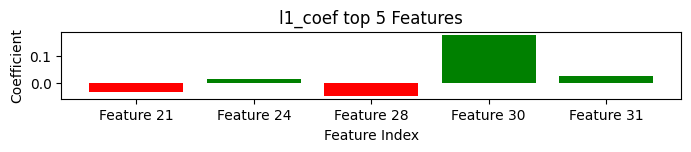

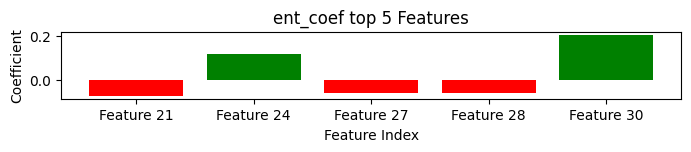

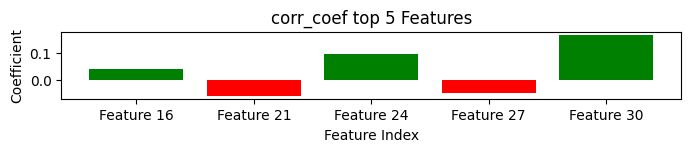

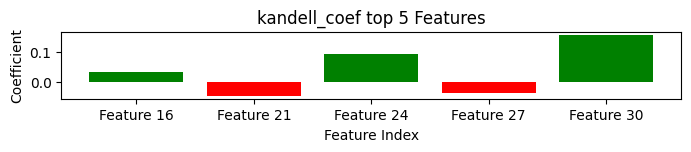

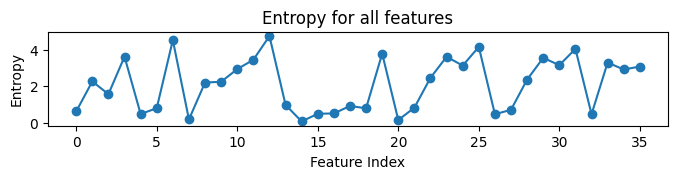

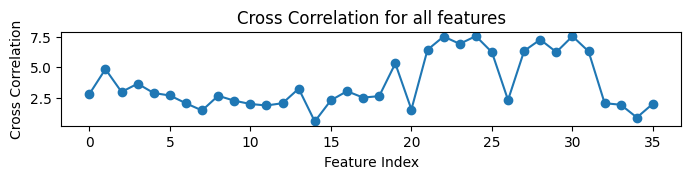

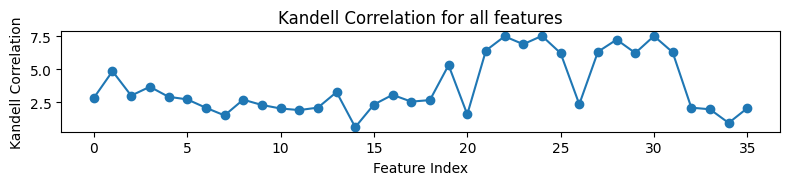

In [76]:
def test_per_ds(dataset:MyDataset,max_features:int, vis: bool=True):
  ent_util = EntropyRegularizerFeatureSelector(dataset.data.to_numpy())
  selector_ent=MyRegulaizerBase(dataset.data.to_numpy(),dataset.labels.to_numpy(),ent_util)
  entropy_features,ent_coef=selector_ent.get_features_and_coef(max_features)


  kandell_util = KandellCorrRegularizerFeatureSelector(dataset.data.to_numpy())
  selector_kandell=MyRegulaizerBase(dataset.data.to_numpy(),dataset.labels.to_numpy(),kandell_util)
  kandell_features,kandell_coef=selector_kandell.get_features_and_coef(max_features)

  kandell_features_score, n_kandell_features = test_features_for_dataset(dataset.name,kandell_features[0], max_features)

  corr_util = CrossCorrRegularizerFeatureSelector(dataset.data.to_numpy())
  selector_corr=MyRegulaizerBase(dataset.data.to_numpy(),dataset.labels.to_numpy(),corr_util)
  corr_features,corr_coef=selector_corr.get_features_and_coef(max_features)

  corr_features_score, n_corr_features = test_features_for_dataset(dataset.name,corr_features[0], max_features)

  l1_feat,l1_clean_coef=get_features_by_l1(dataset.data.to_numpy(),dataset.labels.to_numpy(),max_features, vis=vis)
  l1_score, n_l1_features = test_features_for_dataset(dataset.name,l1_feat[0], max_features)

  entropy_feat_score, n_entropy_features = test_features_for_dataset(dataset.name,entropy_features[0], max_features)

  auto_fs_score, base_score, auto_fs_n_selected_features =\
  test_benchmark_for_dataset(dataset.name,max_features)

  if not vis:
    return corr_features_score, n_corr_features, l1_score, n_l1_features, entropy_feat_score, n_entropy_features, auto_fs_score, auto_fs_n_selected_features, base_score

  print("l1_score",l1_score)
  print("cross corr score",corr_features_score)
  print("kandell_features_score",kandell_features_score)
  print("entropy_feat_score",entropy_feat_score)
  print("auto_fs_score",auto_fs_score)
  print("base_score",base_score)

  visualize({"l1_coef":l1_clean_coef,"ent_coef":ent_coef,"corr_coef":corr_coef,"kandell_coef":kandell_coef},ent_util.feature_entropies,corr_util.feature_correlations,
            kandell_util.feature_correlations,max_features)

# Example test for the Students grade dataset and 5 features
test_per_ds(db[0],5)

In [77]:
corr_features_score, n_corr_features, l1_score, n_l1_features, entropy_feat_score, n_entropy_features, auto_fs_score, auto_fs_n_selected_features, base_score = test_per_ds(db[0],10, False)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [78]:
def run_f_and_store_values(ds, names, max_features):
    values = {names[0]: [], names[1]: [], names[2]: [], names[3]: [], names[4]: []}

    for idx, input_val in enumerate(max_features):
        output = test_per_ds(ds, input_val, vis=False)
        for j in range(len(names)):
          values[names[j]].append(output[j*2])

    return values

# Example usage:
names = ['corr features score', 'l1 score', 'entropy feat score', 'auto fs score', 'base score']
max_features = [5, 10, 15]
result = run_f_and_store_values(db[0], names, max_features)
print(result)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


{'corr features score': [0.7394578313253012, 0.75, 0.7560240963855421], 'l1 score': [0.7356927710843374, 0.7417168674698795, 0.7590361445783133], 'entropy feat score': [0.7424698795180723, 0.7560240963855421, 0.7522590361445783], 'auto fs score': [0.7274096385542169, 0.7394578313253012, 0.7605421686746988], 'base score': [0.759789156626506, 0.759789156626506, 0.759789156626506]}


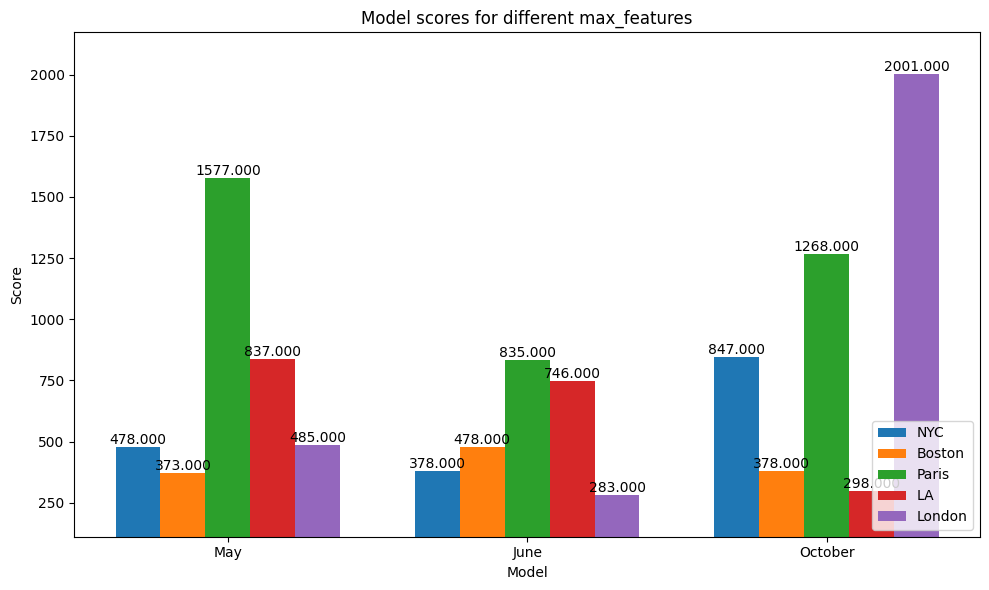

In [79]:
import matplotlib.pyplot as plt

def draw_hist(model_names, max_features, scores, ylabel='Score', title='Model scores for different max_features'):

  max_val = max(max(sublist) for sublist in scores.values())
  min_val = min(min(sublist) for sublist in scores.values())
  spacing = (max_val - min_val)/10

  # Plotting
  fig, ax = plt.subplots(figsize=(10, 6))

  bar_width = 0.15
  index = range(len(max_features))

  colors = ['blue', 'orange', 'green', 'red', 'purple']

  for i, m in enumerate(model_names):
      plt.bar([x + i * bar_width for x in index], scores[m], bar_width, label=m)

  plt.xlabel('Model')
  plt.ylabel(ylabel)
  plt.title(title)
  # Move the legend to the bottom right corner
  plt.legend(loc='lower right')

  plt.xticks([i + bar_width * 2 for i in index], months)
  plt.ylim(min_val - spacing, max_val + spacing)  # Set y-axis limits to emphasize differences

  # Add data labels
  for i, m in enumerate(model_names):
      for j, score in enumerate(scores[m]):
          plt.text(j + i * bar_width, score, f'{score:.3f}', ha='center', va='bottom')

  plt.tight_layout()
  plt.show()

cities = ['NYC', 'Boston', 'Paris', 'LA', 'London']
months = ['May', 'June', 'October']
scores = {
    'NYC': [478, 378, 847],
    'Boston': [373, 478, 378],
    'Paris': [1577, 835, 1268],
    'LA': [837, 746, 298],
    'London': [485, 283, 2001]
}
draw_hist(cities, months, scores)

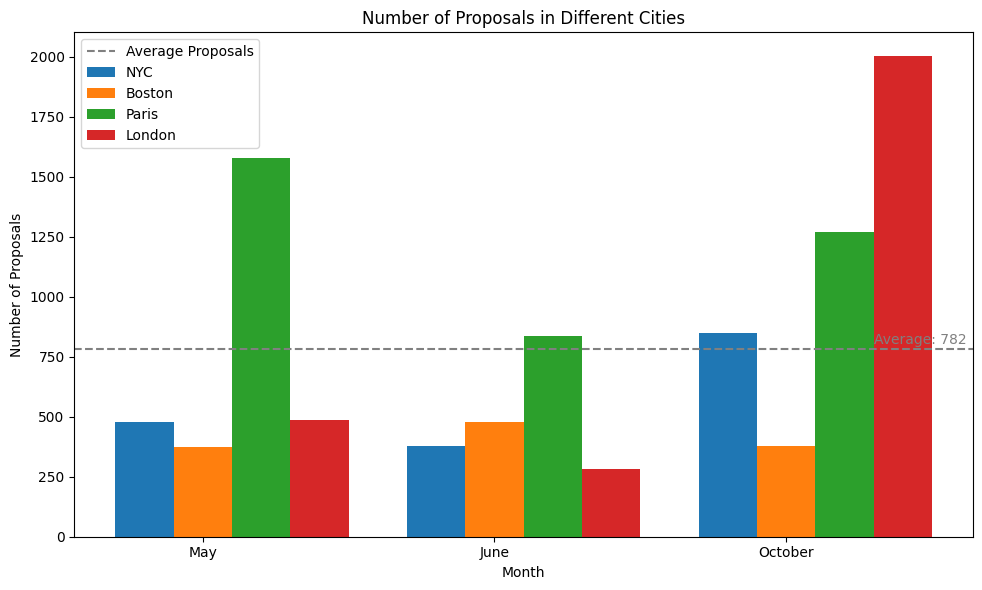

In [80]:
import matplotlib.pyplot as plt
import numpy as np

# Data
cities = ['NYC', 'Boston', 'Paris', 'London']
months = ['May', 'June', 'October']
proposals = {
    'NYC': [478, 378, 847],
    'Boston': [373, 478, 378],
    'Paris': [1577, 835, 1268],
    'London': [485, 283, 2001]
}

# Calculate average number of proposals
avg_proposals = np.mean([val for sublist in proposals.values() for val in sublist])

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2
index = range(len(months))

for i, city in enumerate(cities):
    plt.bar([x + i * bar_width for x in index], proposals[city], bar_width, label=city)

plt.axhline(y=avg_proposals, color='gray', linestyle='--', label='Average Proposals')
plt.text(len(months) - 0.5, avg_proposals + 20, f'Average: {avg_proposals:.0f}', color='gray')

plt.xlabel('Month')
plt.ylabel('Number of Proposals')
plt.title('Number of Proposals in Different Cities')
plt.xticks([r + bar_width for r in range(len(months))], months)
plt.legend()
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


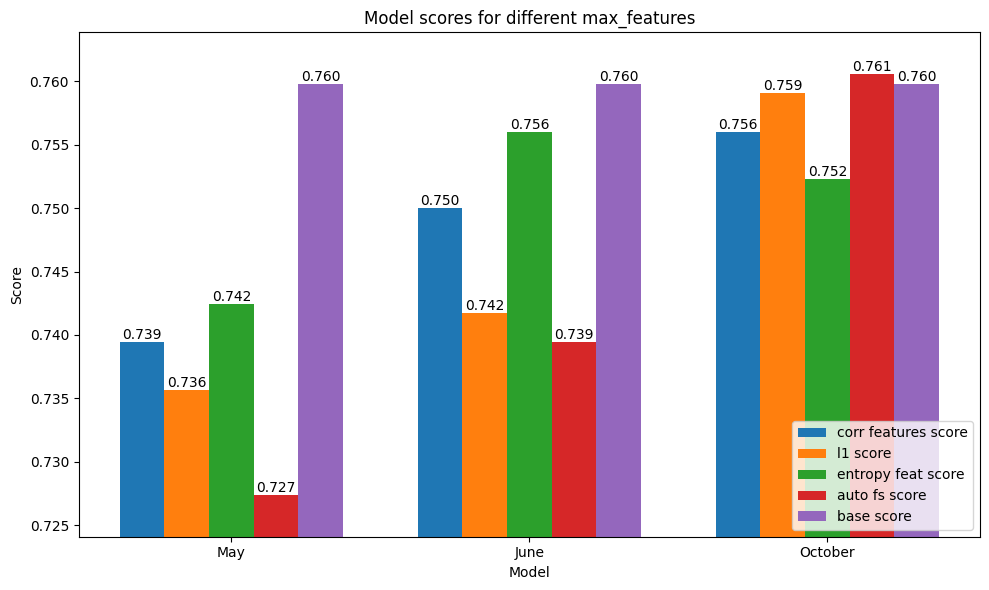

In [81]:
def draw_ds_hist(ds):
  names = ['corr features score', 'l1 score', 'entropy feat score', 'auto fs score', 'base score']
  max_features = [5, 10, 15]
  data = run_f_and_store_values(db[0], names, max_features)
  draw_hist(names, max_features, data)

draw_ds_hist(db[0])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


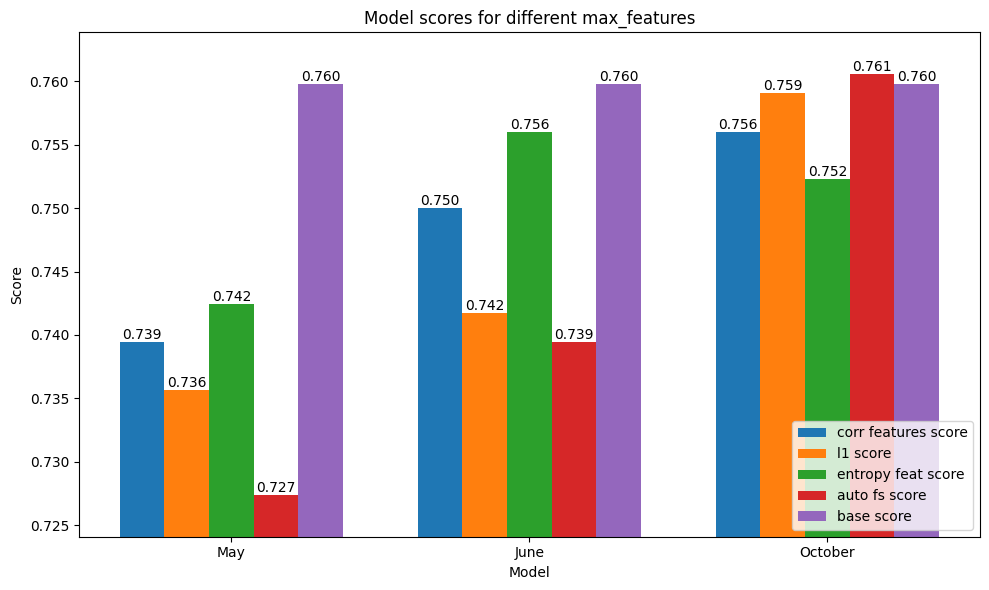

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


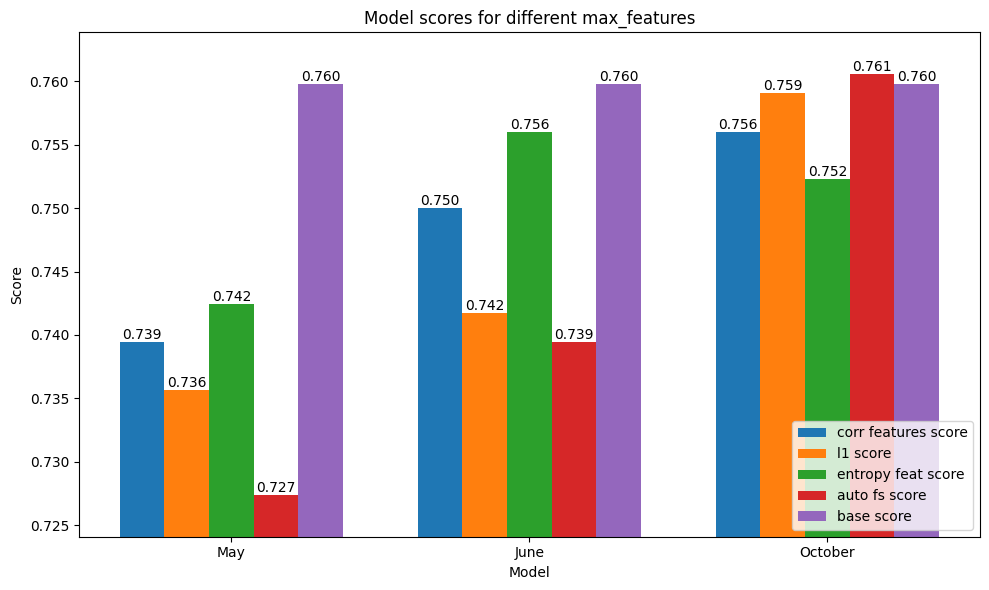

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


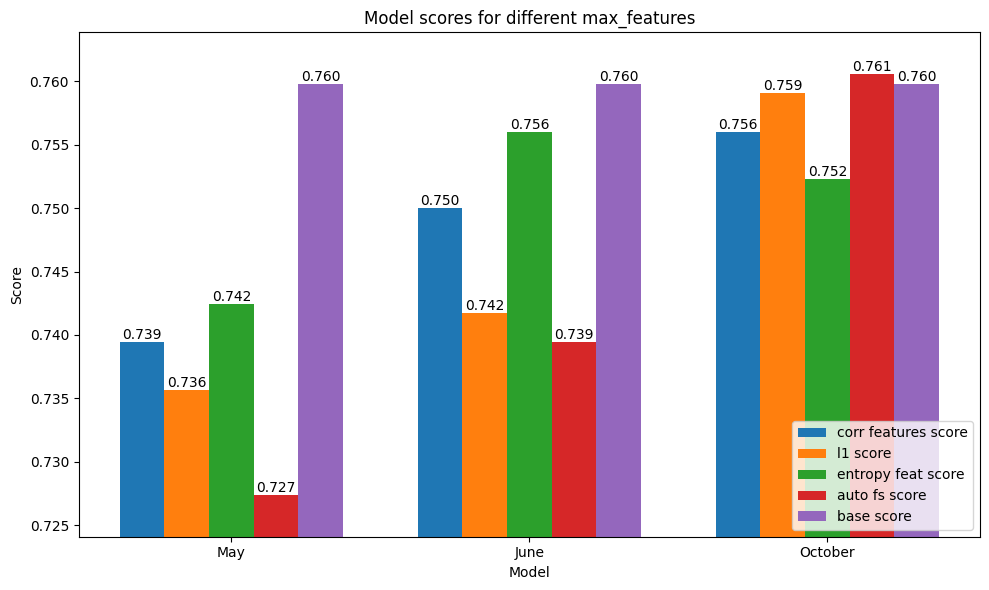

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


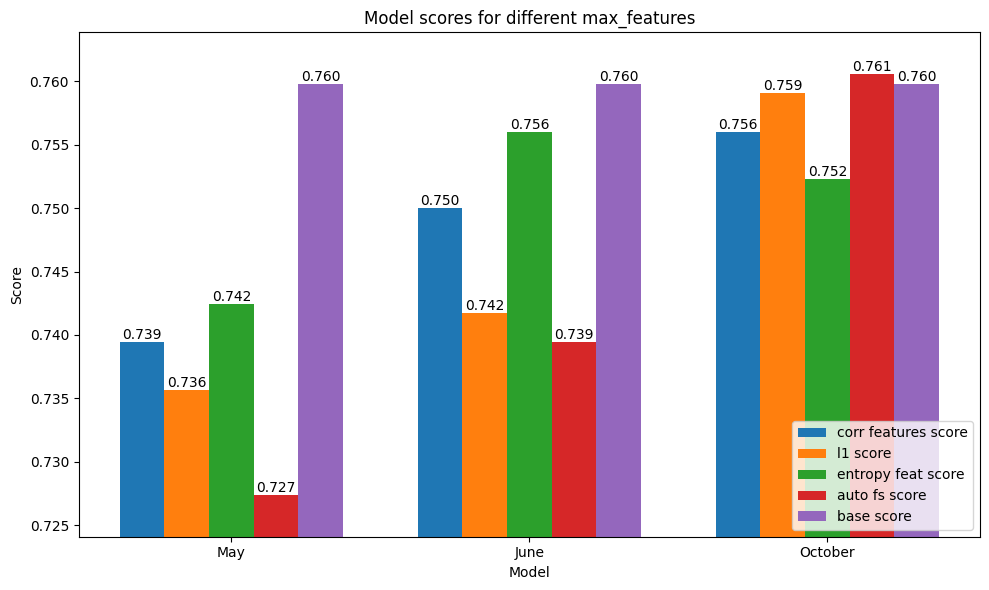

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


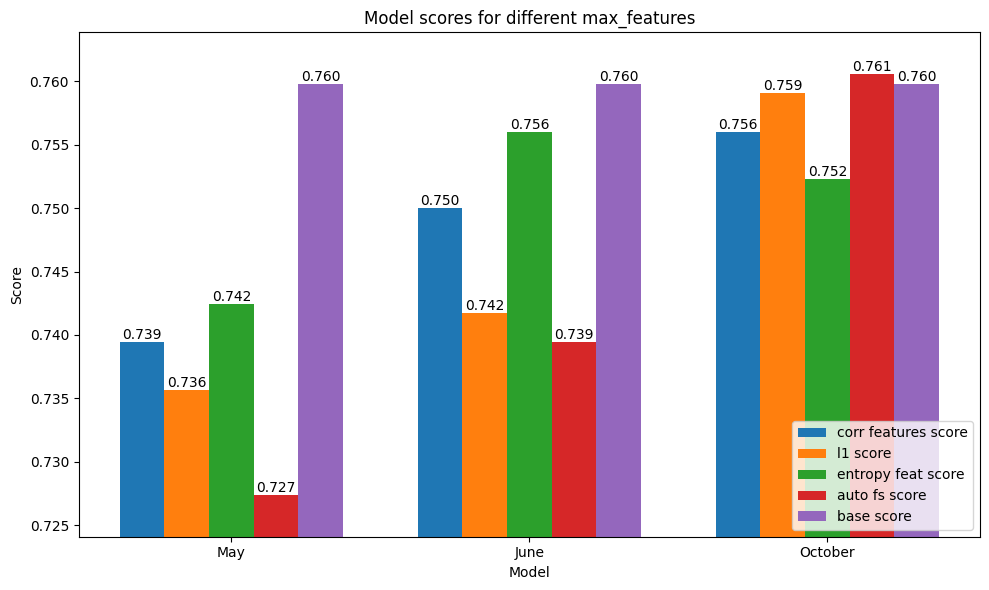

In [82]:
for ds in db:
  draw_ds_hist(ds)